#### <b>[코드 구현] DCGAN</b>

* <b>작성자</b>: 나동빈(dongbinna@postech.ac.kr)
* Deep Convolutional Generative Adversarial Networks <b>(ICLR 2016)</b>
* 본 소스코드는 원본 논문에서 제안한 아키텍처를 최대한 따르고 있습니다.
* Convoluational Layer를 활용하여 이미지 생성에 높은 성능을 보이는 DCGAN 모델을 학습해 봅시다.
* 학습 데이터셋: <b>Face Mask (흑백 이미지)</b>
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.

#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b>학습 데이터셋 불러오기</b>

* 학습을 위해 <b>Face Mask (Grayscale)</b> 데이터셋을 불러옵니다.

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdvkqQvoAPdLrUgxYpXF4TYBugvWlhZMsh-YmQ6bIaXFQQ?download=1 -O face_mask_dataset_by_pranavsingaraju.zip

--2020-12-26 12:46:31--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdvkqQvoAPdLrUgxYpXF4TYBugvWlhZMsh-YmQ6bIaXFQQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/face_mask_dataset_by_pranavsingaraju.zip?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZHZrcVF2b0FQZExyVWd4WXBYRjRUWUJ1Z3ZXbGhaTXNoLVltUTZiSWFYRlFRP3J0aW1lPXV4ZFdTSnlwMkVn [following]
--2020-12-26 12:46:37--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/face_mask_dataset_by_pranavsingaraju.zip?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zd

In [3]:
%%capture
!unzip face_mask_dataset_by_pranavsingaraju.zip -d ./

In [4]:
print("학습용 WithMask 데이터셋 개수", len(next(os.walk('./new_with_mask'))[2]))
print("학습용 WithoutMask 데이터셋 개수", len(next(os.walk('./new_without_mask'))[2]))

학습용 WithMask 데이터셋 개수 10000
학습용 WithoutMask 데이터셋 개수 10000


* 학습 데이터셋을 출력해 봅시다.

이미지 크기: (224, 224)


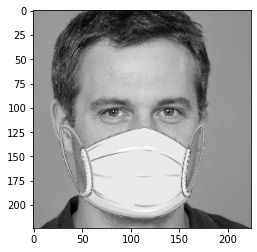

이미지 크기: (224, 224)


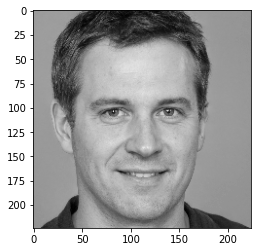

In [5]:
# 마스크를 쓴 이미지 출력
image = Image.open('./new_with_mask/with-mask-default-mask-seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

# 마스크를 쓰지 않은 이미지 출력
image = Image.open('./new_without_mask/seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

* 커스텀 데이터셋(Custom Dataset) 클래스를 정의합니다.
* <b>학습/평가/테스트 데이터셋을 모두 이용</b>합니다.

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join(root, f"new_with_mask") + "/*.png"))
        self.files.extend(sorted(glob.glob(os.path.join(root, f"new_without_mask") + "/*.png")))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)

        return img

    def __len__(self):
        return len(self.files)

In [7]:
transforms_ = transforms.Compose([
    transforms.Resize((64, 64), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageDataset("./", transforms_=transforms_)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

* CNN 연산을 위하여 이미지의 크기를 1 X 64 X 64 형태로 변경하여 사용합니다. (2의 거듭제곱수)

In [8]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 4 # 원본 크기보다 16배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim, 512 * self.init_size * self.init_size)) # 초기 채널의 크기는 512 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 1로
            nn.Tanh(),
        )

    def forward(self, z):
        output = self.layer1(z)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output

In [9]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(1, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        output = self.conv_blocks(img)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [11]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.679678] [G loss: 0.684213] [Elapsed time: 35.67s]
[Epoch 1/200] [D loss: 0.735044] [G loss: 0.650509] [Elapsed time: 72.47s]
[Epoch 2/200] [D loss: 0.674672] [G loss: 0.738052] [Elapsed time: 108.81s]
[Epoch 3/200] [D loss: 0.670646] [G loss: 0.718160] [Elapsed time: 145.14s]
[Epoch 4/200] [D loss: 0.666461] [G loss: 0.795137] [Elapsed time: 181.58s]
[Epoch 5/200] [D loss: 0.680608] [G loss: 0.723675] [Elapsed time: 217.83s]
[Epoch 6/200] [D loss: 0.444071] [G loss: 1.665394] [Elapsed time: 254.28s]
[Epoch 7/200] [D loss: 0.521074] [G loss: 1.298475] [Elapsed time: 290.74s]
[Epoch 8/200] [D loss: 0.571277] [G loss: 1.007878] [Elapsed time: 327.21s]
[Epoch 9/200] [D loss: 0.897826] [G loss: 1.679954] [Elapsed time: 363.70s]
[Epoch 10/200] [D loss: 0.293839] [G loss: 0.923266] [Elapsed time: 400.21s]
[Epoch 11/200] [D loss: 0.310558] [G loss: 1.384586] [Elapsed time: 436.61s]
[Epoch 12/200] [D loss: 0.514915] [G loss: 0.841264] [Elapsed time: 473.28s]
[Epoch 13/2

* 생성된 이미지 예시를 출력합니다.

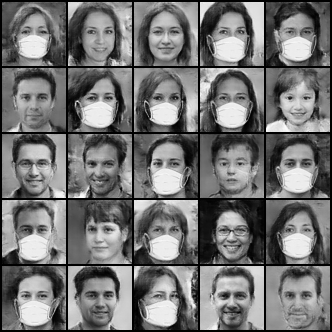

In [12]:
from IPython.display import Image

Image('30000.png')

#### <b>학습된 모델 파라미터 저장 및 테스트</b>

* 다음의 코드를 이용하여 학습된 모델 파라미터를 다운로드받을 수 있습니다.

In [13]:
# 모델 파라미터 저장
torch.save(generator.state_dict(), "Upsampling_DCGAN_Generator_for_Face_Mask.pt")
torch.save(discriminator.state_dict(), "Upsampling_DCGAN_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


In [14]:
# 모델 파라미터 다운로드
from google.colab import files

files.download('Upsampling_DCGAN_Generator_for_Face_Mask.pt')
files.download('Upsampling_DCGAN_Discriminator_for_Face_Mask.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 학습된 모델을 불러와 테스트를 진행할 수 있습니다.

In [10]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb6v0gHgcg1HitX2lqLzkbUB6hr9RZ0LfDjfFaSXrcSgLQ?download=1 -O Upsampling_DCGAN_Generator_for_Face_Mask.pt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERAThboZ0c1Lh1RGQGxrkToB6PxE18nBQA5XR0Zj-oj4kQ?download=1 -O Upsampling_DCGAN_Discriminator_for_Face_Mask.pt

--2020-12-26 12:47:06--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb6v0gHgcg1HitX2lqLzkbUB6hr9RZ0LfDjfFaSXrcSgLQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/DCGAN/Upsampling_DCGAN_Generator_for_Face_Mask.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYjZ2MGdIZ2NnMUhpdFgybHFMemtiVUI2aHI5UlowTGZEamZGYVNYcmNTZ0xRP3J0aW1lPUpNeDBXcHlwMkVn [following]
--2020-12-26 12:47:07--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/DCGAN/Upsampling_DCGAN_Generator_for_Face_Mask.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25

In [48]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("Upsampling_DCGAN_Generator_for_Face_Mask.pt"))
discriminator.load_state_dict(torch.load("Upsampling_DCGAN_Discriminator_for_Face_Mask.pt"))

generator.eval();
discriminator.eval();

In [81]:
# 랜덤 노이즈(noise) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()

# 이미지 생성
generated_imgs = generator(z)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f"result.png", nrow=10, normalize=True)

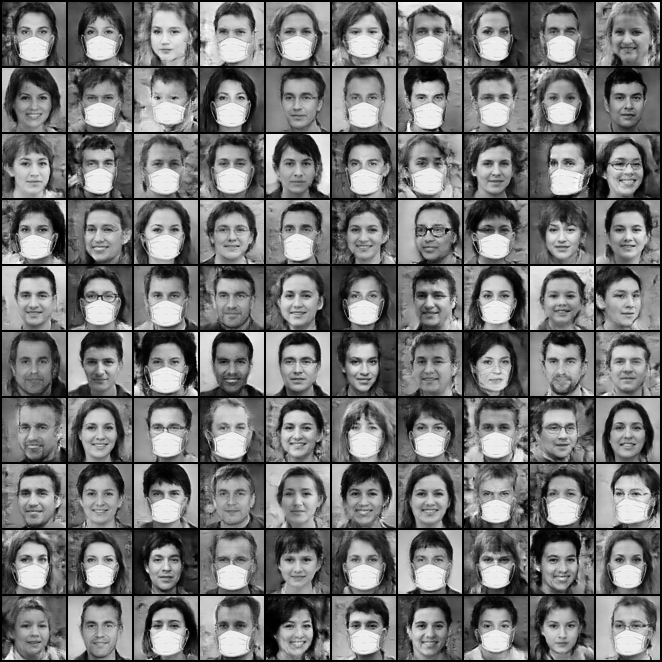

In [82]:
from IPython.display import Image

Image('result.png')

#### <b>노이즈 벡터 연산(Noise Vector Arithmetic) 예시</b>

* 세 가지 <b>노이즈 벡터</b>를 이용합니다.
    * 마스크를 쓴 남성의 평균: man_with_mask
    * 마스크를 쓰지 않은 남성의 평균: man_without_mask
    * 마스크를 쓰지 않은 여성의 평균: woman_without_mask

In [83]:
man_with_mask = (z[11].unsqueeze(0) + z[15].unsqueeze(0) + z[16].unsqueeze(0)) / 3
man_without_mask = (z[19].unsqueeze(0) + z[40].unsqueeze(0) + z[91].unsqueeze(0)) / 3
woman_without_mask = (z[2].unsqueeze(0) + z[20].unsqueeze(0) + z[98].unsqueeze(0)) / 3

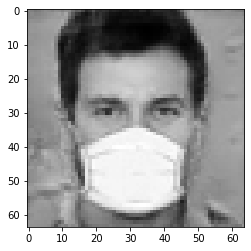

In [84]:
# 마스크를 쓴 남성 출력
generated_img = generator(man_with_mask).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

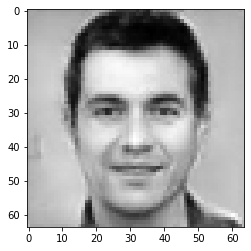

In [85]:
# 마스크를 쓰지 않은 남성 출력
generated_img = generator(man_without_mask).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

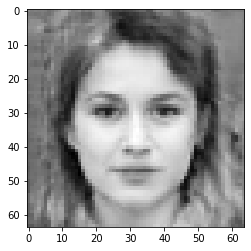

In [86]:
# 마스크를 쓰지 않은 여성 출력
generated_img = generator(woman_without_mask).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

* <b>마스크를 쓴 여성</b>: woman_with_mask = man_with_mask - man_without_mask + woman_without_mask
* 결과적으로 만들어진 벡터를 시각화합니다.

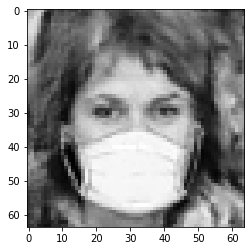

In [88]:
# 마스크를 쓴 여성 출력
woman_with_mask = man_with_mask - man_without_mask + woman_without_mask
generated_img = generator(woman_with_mask).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

#### <b>노이즈 벡터 보간법(Noise Vector Interpolation) 예시</b>

* 두 가지 <b>노이즈 벡터</b>를 이용합니다.
    * 왼쪽을 보고 있는 남성: man_left
    * 오른쪽을 보고 있는 남성: man_right

In [89]:
man_left = z[70].unsqueeze(0)
man_right = z[19].unsqueeze(0)

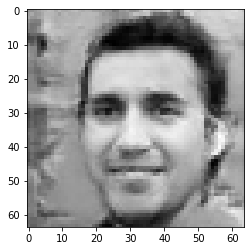

In [90]:
# 왼쪽을 보고 있는 남성 출력
generated_img = generator(man_left).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

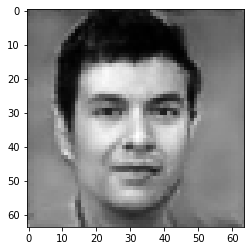

In [91]:
# 오른쪽을 보고 있는 남성 출력
generated_img = generator(man_right).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

* 두 노이즈 벡터 사이에서 <b>보간법(interpolation)</b>을 진행하며 결과를 출력합니다.

In [146]:
current = torch.Tensor(size=(10, 100)).cuda()
for i in range(10):
    current[i] = (man_left.squeeze(0) * (i / 9) + man_right.squeeze(0) * ((9 - i) / 9))

# 이미지 출력
generated_imgs = generator(current).detach().cpu()
save_image(generated_imgs.data, f"interpolation.png", nrow=10, normalize=True)

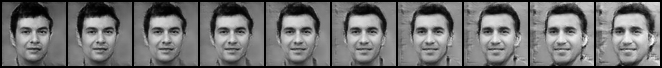

In [147]:
from IPython.display import Image

Image('interpolation.png')